In [1]:
import pandas
import datetime
import matplotlib.pyplot as pyplot

# Data comparison with Rijkswaterstaat

Earlier analysis in the data shows that problems occur in the temperature sensor after the replacement of the door parts. The measurements flatline where they are expected to fluctuate with weather. In this document, research will be done by comparing the data from rijkswaterstaat with the data in our dataset.

In [2]:
received_data = pandas.read_csv('data.csv')
rijkswaterstaat_data = pandas.read_csv('external.csv', delimiter=';')

In [3]:
received_data['datetime'] = pandas.to_datetime(received_data['datetime'])

## Removing all other data

For this experiment, the water_temperatur is the only measurement of interest. All the other data will be dropped for the sake of consitency. The water_temperature_C column will also be renamed for clearity. This leaves the following columns. Undercarriage replacement can still be relevant considering the issues arrise after replacement of the part. There are also some outliers in the original data which shall be removed.

In [4]:
droppable_columns = ['file_name', 'lock_movement', 'water_level_cmNAP', 'air_temperature_01C', 'energy_proxy']
renamable_columns = {'water_temperature_C': 'water_temperature'}

filtered_data = pandas.DataFrame(received_data)
filtered_data = filtered_data.drop(columns=droppable_columns)
filtered_data = filtered_data.rename(columns=renamable_columns)
filtered_data = filtered_data[filtered_data['water_temperature'] < 50]

filtered_data

,datetime,undercarriage_replacement,water_temperature
0,2020-07-06 13:17:12,0,18.1
1,2020-07-06 13:18:53,0,18.1
2,2020-07-06 16:08:17,0,18.5
3,2020-07-06 16:17:10,0,18.2
4,2020-07-06 17:32:38,0,18.2
...,...,...,...
6609,2023-08-15 04:59:59,1,8.8
6610,2023-08-15 05:38:35,1,8.8
6611,2023-08-15 06:44:18,1,8.8
6612,2023-08-15 07:01:42,1,8.8


The dataset received from rijkswaterstaat has a lot of columns describing the data. In order to get to a dataset useable for comparison, it is better to start with an empty data frame and add the columns needed, instead of removing everything not needed.

In [5]:
rijkswaterstaat_data.head()

comparable_data = pandas.DataFrame()
comparable_data['date'] = rijkswaterstaat_data['WAARNEMINGDATUM']
comparable_data['time'] = rijkswaterstaat_data['WAARNEMINGTIJD (MET/CET)']
comparable_data['water_temperature'] = rijkswaterstaat_data['NUMERIEKEWAARDE']
comparable_data = comparable_data[::2]

comparable_data['date'] = pandas.to_datetime(comparable_data['date'], format="%d-%m-%Y").dt.date
comparable_data['time'] = pandas.to_datetime(comparable_data['time'], format="%H:%M:%S").dt.time

comparable_data

,date,time,water_temperature
0,2021-12-24,00:00:00,999999999999
2,2021-12-24,00:10:00,999999999999
4,2021-12-24,00:20:00,999999999999
6,2021-12-24,00:30:00,999999999999
8,2021-12-24,00:40:00,999999999999
...,...,...,...
172790,2023-08-15,23:10:00,"20,3"
172792,2023-08-15,23:20:00,"20,3"
172794,2023-08-15,23:30:00,"20,4"
172796,2023-08-15,23:40:00,"20,3"


## Checking the problem

Before continueing, it is usefull to determine the actual problem we're trying to solve. The issue is some flatlining in watertemperature after the undercarriage got replaced. This can be seen in the graph below.

<Axes: xlabel='datetime', ylabel='water_temperature'>

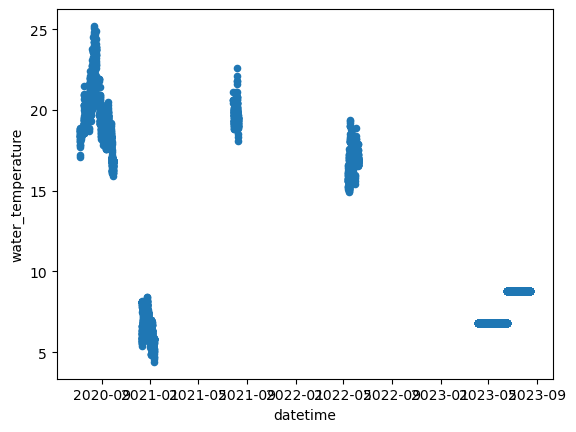

In [6]:
filtered_data.plot.scatter('datetime', 'water_temperature')


This difference becomes more obvious when we display the data for only after the undercarriage replacement. The sensor seems to working fine at first, after which something happens to flatline the sensor.

<Axes: xlabel='datetime', ylabel='water_temperature'>

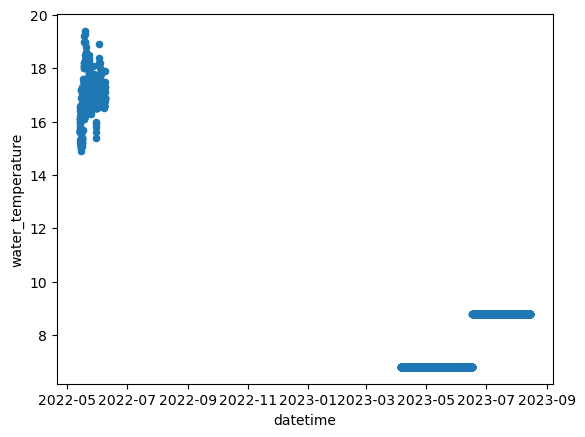

In [7]:
after_replacement = filtered_data[filtered_data['undercarriage_replacement'] == 1]
after_replacement.plot.scatter('datetime', 'water_temperature')

Since the drop in temperature goes to below 8 in the dataset, it is easy to determine the first moment the readings start to fail. In order to get all the values with a problem, all temperatures below 12 will be added to a new data frame. This way, we determine the first error to be at **2023-04-05**.

In [8]:
problematic_data = after_replacement[after_replacement['water_temperature'] < 10]
problematic_data.head()

,datetime,undercarriage_replacement,water_temperature
3357,2023-04-05 10:27:40,1,6.8
3358,2023-04-05 10:50:45,1,6.8
3359,2023-04-05 12:01:34,1,6.8
3360,2023-04-05 12:31:12,1,6.8
3361,2023-04-05 13:36:16,1,6.8


## Comparing with Rijkswaterstaat

Now it's time to put the claims to the test and start looking for inside the data of rijkswaterstaat whether this can aid our research. This is done by taking the date *2023-04-05* and filtering on that.

In [9]:
ranged_data = pandas.DataFrame(comparable_data)
ranged_data['date'] = pandas.to_datetime(ranged_data['date'], format="%d-%m-%Y")
ranged_data['time'] = pandas.to_datetime(ranged_data['time'], format="%H:%M:%S")
ranged_data['time'] = ranged_data['time'].dt.time

ranged_data = ranged_data[ranged_data['date'] >= '05-04-2023']
ranged_data[ranged_data['time'] > datetime.time(10, 00, 00)]

,date,time,water_temperature
142970,2023-05-04,10:10:00,"13,1"
142972,2023-05-04,10:20:00,"13,1"
142974,2023-05-04,10:30:00,"13,1"
142976,2023-05-04,10:40:00,"13,1"
142978,2023-05-04,10:50:00,"13,2"
...,...,...,...
172790,2023-08-15,23:10:00,"20,3"
172792,2023-08-15,23:20:00,"20,3"
172794,2023-08-15,23:30:00,"20,4"
172796,2023-08-15,23:40:00,"20,3"


## Making sure it fits

The data might be usable from a quality point of view, replacing the problematic values in the original data with good ones, however; there are some potential issues. We need to make sure that the data froms Rijkswaterstaat actually matches the data we have. If they differ too much, we might cause an unbalance in the results. The way to do this, is to compare two point of the sets we know are correct with each other.

In [10]:
after_replacement.head()

,datetime,undercarriage_replacement,water_temperature
2709,2022-05-13 08:49:18,1,15.6
2710,2022-05-13 10:01:49,1,15.6
2712,2022-05-13 11:22:50,1,15.6
2714,2022-05-13 13:05:51,1,15.7
2715,2022-05-13 13:21:31,1,15.7


In [11]:
check_data = pandas.DataFrame(comparable_data)
check_data['date'] = pandas.to_datetime(check_data['date'], format="%d-%m-%Y")
check_data['time'] = pandas.to_datetime(check_data['time'], format="%H:%M:%S")
check_data['time'] = check_data['time'].dt.time

check_data = check_data[check_data['date'] >= '13-05-2022']
check_data[check_data['time'] > datetime.time(8, 30, 00)]

,date,time,water_temperature
40424,2022-05-13,08:40:00,"16,4"
40426,2022-05-13,08:50:00,"16,4"
40428,2022-05-13,09:00:00,"16,2"
40430,2022-05-13,09:10:00,"16,2"
40432,2022-05-13,09:20:00,"16,4"
...,...,...,...
172790,2023-08-15,23:10:00,"20,3"
172792,2023-08-15,23:20:00,"20,3"
172794,2023-08-15,23:30:00,"20,4"
172796,2023-08-15,23:40:00,"20,3"


From this one instance, it can be determined that data is quite similar, precise enough for the replacement. This is how the issue with the data will be fought.

## Replacing the values

The last step in the research for this subject is to actually replace the incorrect values and to determine whether the problem is fixed. The only issue faced during this step is the fact that the original measurements times don't match the ones in the dataset. The plan is to round these times down during interpolation, since the difference of maximum 10 minutes won't effect the results too much.

In [12]:
dated_problematic_data = pandas.DataFrame(problematic_data)
dated_problematic_data['datetime'] = pandas.to_datetime(dated_problematic_data['datetime'], format="%Y-%m-%d %H:%M:%S")

dated_problematic_data['date'] = dated_problematic_data['datetime'].dt.date
dated_problematic_data['floored_time'] = (dated_problematic_data['datetime'].dt.floor('10min')).dt.time

dated_problematic_data.head()

,datetime,undercarriage_replacement,water_temperature,date,floored_time
3357,2023-04-05 10:27:40,1,6.8,2023-04-05,10:20:00
3358,2023-04-05 10:50:45,1,6.8,2023-04-05,10:50:00
3359,2023-04-05 12:01:34,1,6.8,2023-04-05,12:00:00
3360,2023-04-05 12:31:12,1,6.8,2023-04-05,12:30:00
3361,2023-04-05 13:36:16,1,6.8,2023-04-05,13:30:00


Now that a column is available containing the floored time, and one containing the date, the data can be matched. Trail and error baby let's go.

In [13]:
merged_problematic_data = pandas.merge(dated_problematic_data, comparable_data, 
                                       left_on=['date', 'floored_time'], 
                                       right_on=['date', 'time'], 
                                       suffixes=('', '_y'))

merged_problematic_data['water_temperature'] = merged_problematic_data['water_temperature_y']
merged_problematic_data = merged_problematic_data.drop(columns=['floored_time', 'time', 'water_temperature_y', 'date'])
merged_problematic_data['water_temperature'] = merged_problematic_data['water_temperature'].str.replace(',', '.')
merged_problematic_data['water_temperature'] = merged_problematic_data['water_temperature'].astype(float)
merged_problematic_data.head()

,datetime,undercarriage_replacement,water_temperature
0,2023-04-05 10:27:40,1,9.3
1,2023-04-05 10:50:45,1,9.3
2,2023-04-05 12:01:34,1,9.4
3,2023-04-05 12:31:12,1,9.4
4,2023-04-05 13:36:16,1,9.6


In [14]:
cleaned_data = pandas.merge(received_data, merged_problematic_data,
                            left_on=['datetime'],
                            right_on=['datetime'],
                            suffixes=('', '_y'),
                            how='left')

cleaned_data['water_temperature_C'] = cleaned_data['water_temperature'].where(cleaned_data['water_temperature'].notnull(), cleaned_data['water_temperature_C'])
cleaned_data = cleaned_data.drop(columns=['undercarriage_replacement_y', 'water_temperature'])
cleaned_data

,file_name,datetime,lock_movement,undercarriage_replacement,water_temperature_C,water_level_cmNAP,air_temperature_01C,energy_proxy
0,DVS1ZP_Converted/20200706_131712.txt,2020-07-06 13:17:12,closing,0,18.1,19.0,138.0,3044749.0
1,DVS1ZP_Converted/20200706_131853.txt,2020-07-06 13:18:53,closing,0,18.1,19.0,138.0,880237.0
2,DVS1ZP_Converted/20200706_160817.txt,2020-07-06 16:08:17,closing,0,18.5,202.0,138.0,6640.0
3,DVS1ZP_Converted/20200706_161710.txt,2020-07-06 16:17:10,closing,0,18.2,201.0,138.0,0.0
4,DVS1ZP_Converted/20200706_173238.txt,2020-07-06 17:32:38,opening,0,18.2,198.0,138.0,3795221.0
...,...,...,...,...,...,...,...,...
6609,DVS1ZP_Converted/20230815_045959.txt,2023-08-15 04:59:59,opening,1,20.1,92.0,124.0,2791437.0
6610,DVS1ZP_Converted/20230815_053835.txt,2023-08-15 05:38:35,closing,1,20.1,51.0,124.0,2192937.0
6611,DVS1ZP_Converted/20230815_064418.txt,2023-08-15 06:44:18,opening,1,20.1,-14.0,124.0,2629123.0
6612,DVS1ZP_Converted/20230815_070142.txt,2023-08-15 07:01:42,closing,1,20.1,-38.0,124.0,2155968.0


<Axes: xlabel='datetime', ylabel='water_temperature_C'>

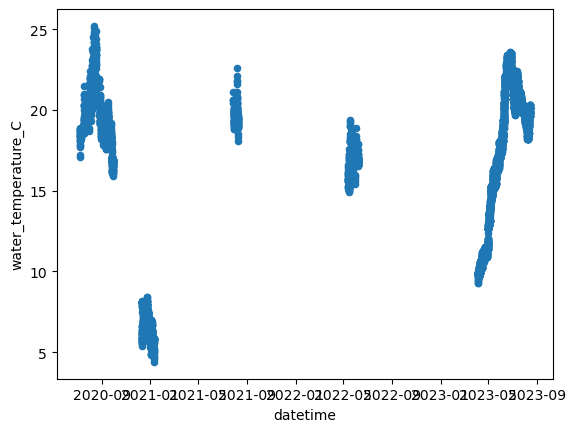

In [15]:
cleaned_data = cleaned_data[cleaned_data['water_temperature_C'] < 50]
cleaned_data.plot.scatter('datetime', 'water_temperature_C')

C:\Users\erjbr\AppData\Local\Temp\ipykernel_25644\3148033450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['air_temperature_01C'] = cleaned_data['air_temperature_01C'] / 10


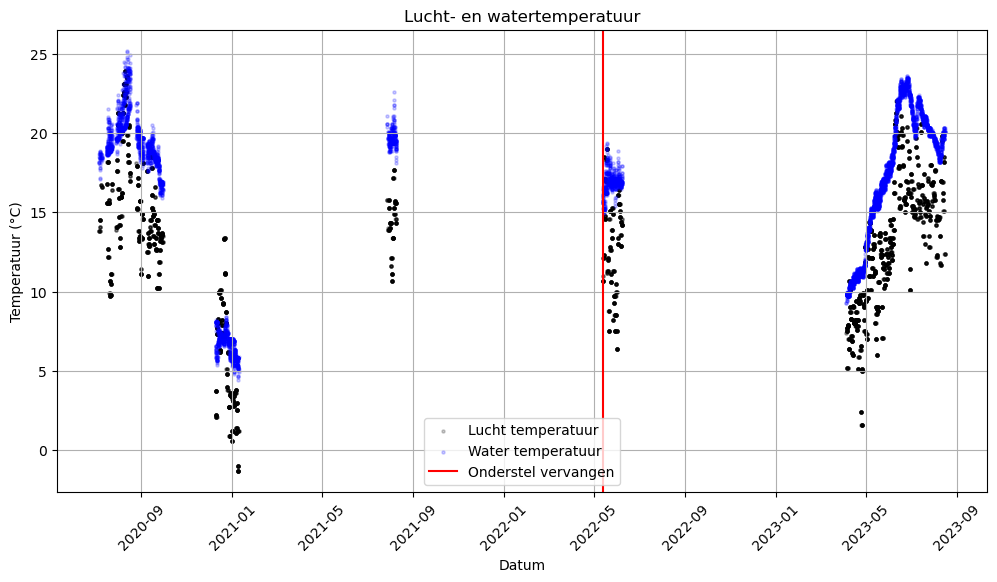

In [16]:
index_verandering = cleaned_data[cleaned_data['undercarriage_replacement'] == 1].index[0]
cleaned_data['air_temperature_01C'] = cleaned_data['air_temperature_01C'] / 10

# Getting the date when the undercarriage was first replaced
datum_verandering = cleaned_data.loc[index_verandering, 'datetime']

# Setting the figure size
pyplot.figure(figsize=(12, 6))

# Plotting air temperature in blue
pyplot.scatter(cleaned_data.datetime, cleaned_data.air_temperature_01C, color='black', s=5, alpha=0.2, label='Lucht temperatuur')

# Plotting water temperature in green
pyplot.scatter(cleaned_data.datetime, cleaned_data.water_temperature_C, color='blue', s=5, alpha=0.2, label='Water temperatuur')

# Setting the title and labels
pyplot.title('Lucht- en watertemperatuur')
pyplot.xlabel('Datum')
pyplot.ylabel('Temperatuur (°C)')

# Rotating the x-axis labels for better readability
pyplot.xticks(rotation=45)

# Adding a grid
pyplot.grid(True)

# Adding a red vertical line to indicate the date of undercarriage replacement
pyplot.axvline(x=datum_verandering, color='red', label='Onderstel vervangen')

# Adding a legend
pyplot.legend()

# Displaying the plot
pyplot.show()

## Removing outliers

The next step is to remove the outliers in energy proxy

In [17]:
cleaned_data.describe()

,datetime,undercarriage_replacement,water_temperature_C,water_level_cmNAP,air_temperature_01C,energy_proxy
count,6601,6601.000000,6601.000000,6.601000e+03,6601.000000,6.601000e+03
mean,2022-04-08 12:37:01.755945984,0.590062,16.381457,7.574698e+05,12.622421,2.901573e+06
min,2020-07-06 13:17:12,0.000000,4.400000,-1.960000e+02,-1.300000,0.000000e+00
25%,2020-12-12 08:11:20,0.000000,13.000000,-8.500000e+01,9.400000,2.561468e+06
50%,2022-06-06 15:43:48,1.000000,18.000000,-1.000000e+00,13.300000,2.840612e+06
75%,2023-05-31 18:21:39,1.000000,20.000000,1.070000e+02,15.700000,3.279415e+06
max,2023-08-15 08:22:12,1.000000,25.200000,1.000000e+09,23.900000,4.232800e+06
std,NaN,0.491859,4.983671,2.751367e+07,4.794704,4.968232e+05


<br>
first, we split the data in before and after the undercarriage replacement

In [18]:
cleaned_before_replacement = cleaned_data[cleaned_data.undercarriage_replacement ==  0]
cleaned_after_replacement = cleaned_data[cleaned_data.undercarriage_replacement ==  1]

In [19]:
cleaned_before_replacement

,file_name,datetime,lock_movement,undercarriage_replacement,water_temperature_C,water_level_cmNAP,air_temperature_01C,energy_proxy
0,DVS1ZP_Converted/20200706_131712.txt,2020-07-06 13:17:12,closing,0,18.1,19.0,13.8,3044749.0
1,DVS1ZP_Converted/20200706_131853.txt,2020-07-06 13:18:53,closing,0,18.1,19.0,13.8,880237.0
2,DVS1ZP_Converted/20200706_160817.txt,2020-07-06 16:08:17,closing,0,18.5,202.0,13.8,6640.0
3,DVS1ZP_Converted/20200706_161710.txt,2020-07-06 16:17:10,closing,0,18.2,201.0,13.8,0.0
4,DVS1ZP_Converted/20200706_173238.txt,2020-07-06 17:32:38,opening,0,18.2,198.0,13.8,3795221.0
...,...,...,...,...,...,...,...,...
2702,DVS1ZP_Converted/20210809_074602.txt,2021-08-09 07:46:02,opening,0,18.5,-32.0,15.6,3798238.0
2703,DVS1ZP_Converted/20210809_075330.txt,2021-08-09 07:53:30,closing,0,18.3,-32.0,15.6,3187327.0
2704,DVS1ZP_Converted/20210809_085932.txt,2021-08-09 08:59:32,opening,0,19.0,-99.0,15.6,3889010.0
2705,DVS1ZP_Converted/20210809_092143.txt,2021-08-09 09:21:43,closing,0,18.1,-109.0,15.6,3350968.0


In [20]:
cleaned_after_replacement

,file_name,datetime,lock_movement,undercarriage_replacement,water_temperature_C,water_level_cmNAP,air_temperature_01C,energy_proxy
2709,DVS1ZP_Converted/20220513_084918.txt,2022-05-13 08:49:18,opening,1,15.6,-95.0,11.0,2401922.0
2710,DVS1ZP_Converted/20220513_100149.txt,2022-05-13 10:01:49,opening,1,15.6,-39.0,11.0,2912658.0
2712,DVS1ZP_Converted/20220513_112250.txt,2022-05-13 11:22:50,opening,1,15.6,59.0,11.0,2802840.0
2714,DVS1ZP_Converted/20220513_130551.txt,2022-05-13 13:05:51,opening,1,15.7,168.0,10.7,2906343.0
2715,DVS1ZP_Converted/20220513_132131.txt,2022-05-13 13:21:31,opening,1,15.7,171.0,10.7,2867409.0
...,...,...,...,...,...,...,...,...
6609,DVS1ZP_Converted/20230815_045959.txt,2023-08-15 04:59:59,opening,1,20.1,92.0,12.4,2791437.0
6610,DVS1ZP_Converted/20230815_053835.txt,2023-08-15 05:38:35,closing,1,20.1,51.0,12.4,2192937.0
6611,DVS1ZP_Converted/20230815_064418.txt,2023-08-15 06:44:18,opening,1,20.1,-14.0,12.4,2629123.0
6612,DVS1ZP_Converted/20230815_070142.txt,2023-08-15 07:01:42,closing,1,20.1,-38.0,12.4,2155968.0


next, we use the std and mean to remove the outliers <br>
here, std * 1.5 is used to differentiate between outliers and normal values. all values outside of the std * 1.5 + mean and std * 1.5 - mean, can be considered as outliers  

In [21]:
outlier_threshold_before = 424007.2 * 1.5
mean_before = 3341879
cleaned_data_before = cleaned_before_replacement[(cleaned_before_replacement['energy_proxy'] <= mean_before +outlier_threshold_before) & (cleaned_before_replacement['energy_proxy'] >= mean_before - outlier_threshold_before)]

In [22]:
cleaned_data_before

,file_name,datetime,lock_movement,undercarriage_replacement,water_temperature_C,water_level_cmNAP,air_temperature_01C,energy_proxy
0,DVS1ZP_Converted/20200706_131712.txt,2020-07-06 13:17:12,closing,0,18.1,19.0,13.8,3044749.0
4,DVS1ZP_Converted/20200706_173238.txt,2020-07-06 17:32:38,opening,0,18.2,198.0,13.8,3795221.0
5,DVS1ZP_Converted/20200706_190034.txt,2020-07-06 19:00:34,opening,0,18.7,73.0,13.8,3681963.0
6,DVS1ZP_Converted/20200706_202747.txt,2020-07-06 20:27:47,opening,0,18.5,-41.0,13.8,3563955.0
7,DVS1ZP_Converted/20200706_211903.txt,2020-07-06 21:19:03,opening,0,18.0,-97.0,13.8,3651022.0
...,...,...,...,...,...,...,...,...
2701,DVS1ZP_Converted/20210809_063743.txt,2021-08-09 06:37:43,closing,0,19.5,52.0,15.6,3317596.0
2702,DVS1ZP_Converted/20210809_074602.txt,2021-08-09 07:46:02,opening,0,18.5,-32.0,15.6,3798238.0
2703,DVS1ZP_Converted/20210809_075330.txt,2021-08-09 07:53:30,closing,0,18.3,-32.0,15.6,3187327.0
2704,DVS1ZP_Converted/20210809_085932.txt,2021-08-09 08:59:32,opening,0,19.0,-99.0,15.6,3889010.0


In [23]:
outlier_threshold_after = 255254.2 * 1.5
mean_after = 2595676
cleaned_data_after = cleaned_after_replacement[(cleaned_after_replacement['energy_proxy'] <= mean_after + outlier_threshold_after) & (cleaned_after_replacement['energy_proxy'] >= mean_after - outlier_threshold_after)]

In [41]:
cleaned_data_after

,file_name,datetime,lock_movement,undercarriage_replacement,water_temperature_C,water_level_cmNAP,air_temperature_01C,energy_proxy
2709,DVS1ZP_Converted/20220513_084918.txt,2022-05-13 08:49:18,opening,1,15.6,-95.0,11.0,2401922.0
2710,DVS1ZP_Converted/20220513_100149.txt,2022-05-13 10:01:49,opening,1,15.6,-39.0,11.0,2912658.0
2712,DVS1ZP_Converted/20220513_112250.txt,2022-05-13 11:22:50,opening,1,15.6,59.0,11.0,2802840.0
2714,DVS1ZP_Converted/20220513_130551.txt,2022-05-13 13:05:51,opening,1,15.7,168.0,10.7,2906343.0
2715,DVS1ZP_Converted/20220513_132131.txt,2022-05-13 13:21:31,opening,1,15.7,171.0,10.7,2867409.0
...,...,...,...,...,...,...,...,...
6606,DVS1ZP_Converted/20230815_000205.txt,2023-08-15 00:02:05,opening,1,20.3,-14.0,12.4,2679450.0
6608,DVS1ZP_Converted/20230815_034130.txt,2023-08-15 03:41:30,opening,1,20.2,171.0,12.4,2680340.0
6609,DVS1ZP_Converted/20230815_045959.txt,2023-08-15 04:59:59,opening,1,20.1,92.0,12.4,2791437.0
6611,DVS1ZP_Converted/20230815_064418.txt,2023-08-15 06:44:18,opening,1,20.1,-14.0,12.4,2629123.0


In [25]:
before_corr = cleaned_data_before.select_dtypes(include=['float64', 'int64']).corr()
after_corr = cleaned_data_after.select_dtypes(include=['float64', 'int64']).corr()
total_corr = cleaned_data.select_dtypes(include=['float64', 'int64']).corr()

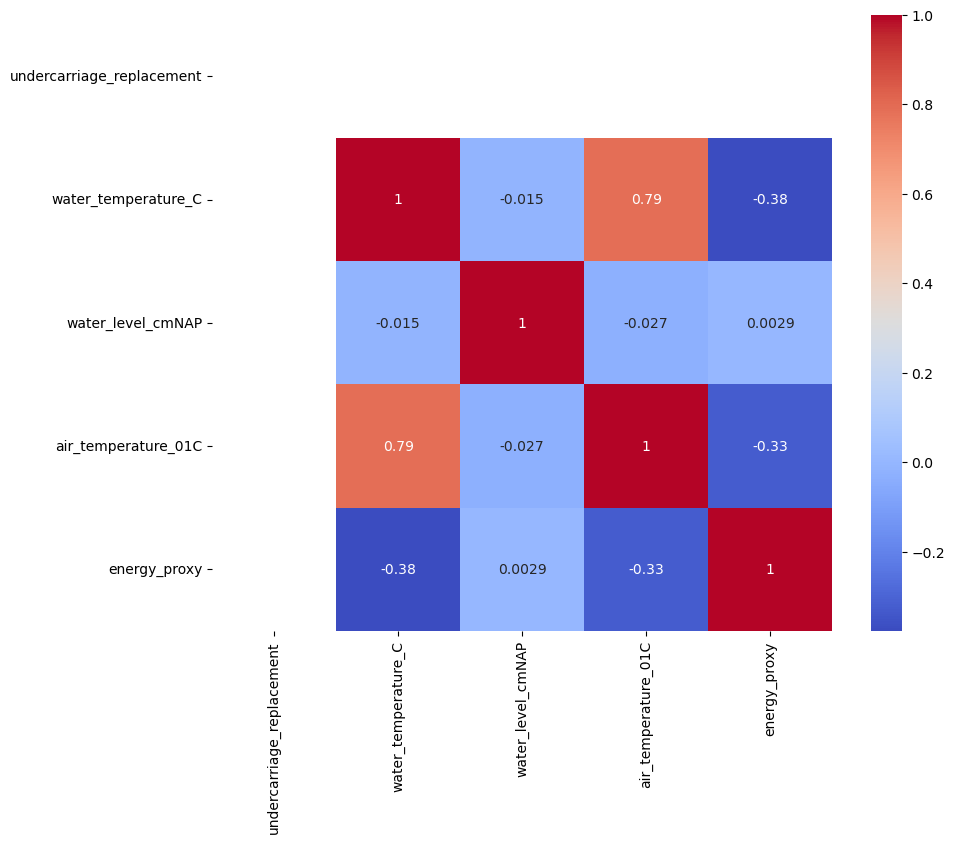

In [26]:
import seaborn

pyplot.figure(figsize=(10, 8))  # Adjust width and height as needed

# Plot the heatmap
seaborn.heatmap(after_corr, annot=True, cmap='coolwarm')

# Show the plot
pyplot.show()

In [27]:
cleaned_data_before.to_csv('cleaned_before.csv', index=False)

In [28]:
cleaned_data_after.to_csv('cleaned_after.csv', index=False)

In [39]:
cleaned_data = pandas.concat([cleaned_data_before, cleaned_data_after], ignore_index=True)

In [1]:
cleaned_data.to_csv('cleaned_all.csv', index=False)

NameError: name 'cleaned_data' is not defined